In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
simulation_results = np.load('npzfiles/CNBDM_results.018.npz')
droplets = simulation_results['droplets']
batch = droplets[0:10000, :]

In [3]:
def fudge_func(x,y,z): return (x+z)*(np.log(x+y) - np.log(x))

In [4]:
zeta = 100

In [5]:
base_relative_abundances = [1e-4, 1e-3, 1e-2]

relative_abundances = [relative_abundance * number
                       for relative_abundance 
                       in base_relative_abundances
                       for number in (1,2,5) 
                       for repeat in range(10)]

relative_abundances += [1-sum(relative_abundances)]
frequencies = np.array(relative_abundances)

In [6]:
S = frequencies.size
rate = 2

In [7]:
droplets_log_fudge_factor_uncorrected = rate - np.sum(droplets, axis=1) + np.sum(fudge_func(zeta*S*frequencies, droplets, droplets - 0.5), axis=1) - \
                                        np.sum(fudge_func(zeta*S*frequencies, frequencies*rate, droplets), axis=1)

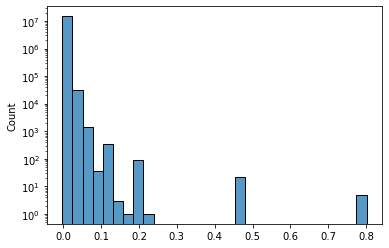

In [8]:
axis = sns.histplot(droplets_log_fudge_factor_uncorrected, bins=30)
axis.set_yscale("log")

In [9]:
def lower_robbins(vector1, vector2, **kwargs):
    result = 1. / (12 * vector1 + 1)
    result -= (1. / (12 * vector2))
    result = np.sum(result, **kwargs)
    return result

In [10]:
def upper_robbins(vector1, vector2, **kwargs):
    result = 1. / (12 * vector1)
    result -= (1. / (12 * vector2 + 1))
    result = np.sum(result, **kwargs)
    return result

In [11]:
lower_robbins_corrections = lower_robbins(zeta*S*frequencies + droplets, zeta*S*frequencies, axis=1)
upper_robbins_corrections = upper_robbins(zeta*S*frequencies + droplets, zeta*S*frequencies, axis=1)

In [12]:
midpoint_robbins_corrections = np.mean([lower_robbins_corrections, upper_robbins_corrections], axis=0)
droplets_log_fudge_factor_corrected = droplets_log_fudge_factor_uncorrected + midpoint_robbins_corrections

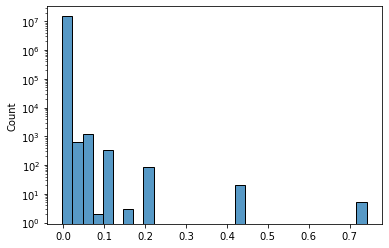

In [13]:
axis = sns.histplot(droplets_log_fudge_factor_corrected, bins=30)
axis.set_yscale("log")

In [14]:
droplets_log_fudge_factor_lower = droplets_log_fudge_factor_uncorrected + lower_robbins_corrections
droplets_log_fudge_factor_upper = droplets_log_fudge_factor_uncorrected + upper_robbins_corrections

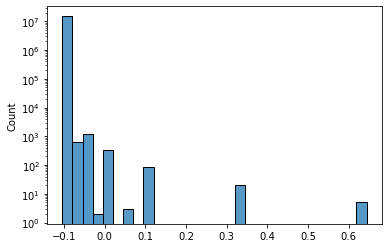

In [15]:
axis = sns.histplot(droplets_log_fudge_factor_lower, bins=30)
axis.set_yscale("log")

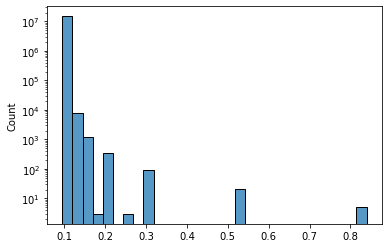

In [16]:
axis = sns.histplot(droplets_log_fudge_factor_upper, bins=30)
axis.set_yscale("log")

## Grouping Droplets

In [17]:
batch.shape

(10000, 91)

In [18]:
all_zero_indices = np.all(batch == 0, axis=1)
all_zero_droplets = batch[all_zero_indices,:]

uncorrected_fudge = np.sum(fudge_func(zeta*S*frequencies, all_zero_droplets, all_zero_droplets - 0.5), axis=1) - fudge_func(zeta*S, np.sum(all_zero_droplets, axis=1), np.sum(all_zero_droplets, axis=1) - 0.5)
uncorrected_fudge

array([0., 0., 0., ..., 0., 0., 0.])

log likelihood ratio (even when including Robbins terms) for all zero droplets is 0, i.e. they are equally likely under both models -- this makes since, both HPM and HPDM are hierarchical Poisson, so the number of all zero droplets should correspond to an indicator RV of the same Poisson

In [20]:
nonzero_counts = {}
for i in range(9):
    nonzero_counts[i] = np.any((droplets[:,i*10:(i+1)*10] > 0), axis=1)

group_median_values_uncorrected = np.zeros((9,9))
group_median_values = np.zeros((9,9))
group_min_values = np.zeros((9,9))
group_max_values = np.zeros((9,9))
    
for i in range(9):
    for j in range(i,9):
        relevant_droplet_indices = nonzero_counts[i] & nonzero_counts[j]
        
        uncorrected_fudge = droplets_log_fudge_factor_uncorrected[relevant_droplet_indices]
        corrected_fudge = droplets_log_fudge_factor_corrected[relevant_droplet_indices]
        lower_fudge = droplets_log_fudge_factor_lower[relevant_droplet_indices]
        upper_fudge = droplets_log_fudge_factor_upper[relevant_droplet_indices]
        
        group_median_values_uncorrected[i,j] = np.median(uncorrected_fudge)
        group_median_values[i,j] = np.median(corrected_fudge)
        try:
            group_min_values[i,j] = np.min(lower_fudge)
        except ValueError:
            group_min_values[i,j] = np.nan
        try:
            group_max_values[i,j] = np.max(upper_fudge)
        except ValueError:
            group_max_values[i,j] = np.nan

In [21]:
def add_ticks(axes_axis):
    axes_axis.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    axes_axis.set_minor_locator(mtick.FixedLocator([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]))
    axes_axis.set_minor_formatter(mtick.FixedFormatter(['.01%', '.02%', '.05%', '0.1%', '0.2%', '0.5%', '1.0%', '2.0%', '5.0%']))

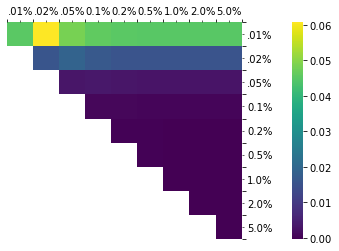

In [22]:
ax = sns.heatmap(group_median_values_uncorrected, cmap="viridis",
                 mask=np.tril(np.ones((9,9)).astype(bool), k=-1), cbar_kws={'pad':0.15})
ax.yaxis.tick_right()
ax.xaxis.tick_top()
add_ticks(ax.xaxis)
add_ticks(ax.yaxis)

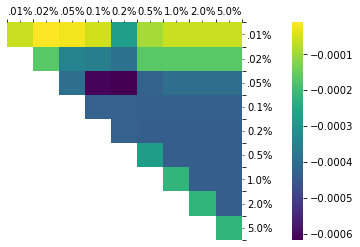

In [23]:
ax = sns.heatmap(group_median_values, cmap="viridis",
                 mask=np.tril(np.ones((9,9)).astype(bool), k=-1), cbar_kws={'pad':0.15})
ax.yaxis.tick_right()
ax.xaxis.tick_top()
add_ticks(ax.xaxis)
add_ticks(ax.yaxis)

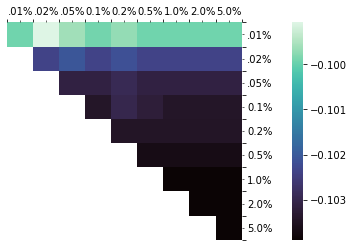

In [24]:
ax = sns.heatmap(group_min_values, cmap="mako",
                 mask=np.tril(np.ones((9,9)).astype(bool), k=-1), cbar_kws={'pad':0.15})
ax.yaxis.tick_right()
ax.xaxis.tick_top()
add_ticks(ax.xaxis)
add_ticks(ax.yaxis)

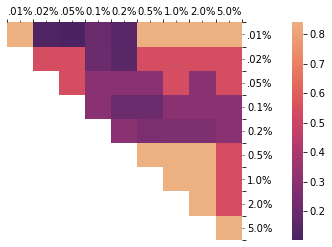

In [25]:
ax = sns.heatmap(group_max_values, cmap="flare_r", 
                 mask=np.tril(np.ones((9,9)).astype(bool), k=-1), cbar_kws={'pad':0.15})
ax.yaxis.tick_right()
ax.xaxis.tick_top()
add_ticks(ax.xaxis)
add_ticks(ax.yaxis)